## 데이터 준비

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('wikipedia-movie-plots.zip')

In [3]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
plot = df['Plot']

## TDM

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [280]:
cv = CountVectorizer(max_features=2000, stop_words='english')

In [281]:
tdm = cv.fit_transform(plot)

In [282]:
tdm.shape

(34886, 2000)

## One-Hot Encoding

In [11]:
import numpy as np

In [283]:
one_hot = np.eye(2000)

In [284]:
one_hot.shape

(2000, 2000)

In [285]:
one_hot[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [286]:
one_hot[1]

array([0., 1., 0., ..., 0., 0., 0.])

In [287]:
one_hot[2]

array([0., 0., 1., ..., 0., 0., 0.])

In [27]:
import re

In [288]:
words = cv.get_feature_names()

In [289]:
tokens = re.findall(cv.token_pattern, plot[0].lower())

In [290]:
doc = np.zeros((1, 2000))

for token in tokens:
    try:
        i = words.index(token)
        doc += one_hot[i]
    except ValueError:
        pass

In [291]:
np.array_equal(doc, tdm[0, :].toarray())

True

## LSA를 이용한 단어 임베딩

In [68]:
from sklearn.decomposition import TruncatedSVD

In [292]:
svd = TruncatedSVD(n_components=10)

In [293]:
svd.fit(tdm)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
             random_state=None, tol=0.0)

In [255]:
svd.components_.shape

(10, 2000)

In [294]:
word_emb = svd.components_.T

In [295]:
word_emb[:, :2]

array([[ 0.01788853, -0.00519977],
       [ 0.00817457, -0.00181484],
       [ 0.00441817, -0.00077524],
       ...,
       [ 0.067578  , -0.01471096],
       [ 0.0161578 ,  0.00010938],
       [ 0.00512192, -0.00108413]])

In [296]:
word_emb[words.index('money')]

array([ 0.08917883, -0.02654373, -0.01716019, -0.0052897 , -0.02816076,
        0.00142925,  0.14864139, -0.05315207,  0.0121691 , -0.035127  ])

지정된 단어의 번호를 찾는다.

In [297]:
indices = []
target = ['family', 'gun', 'money', 'gang', 'war', 'police', 'friend', 'king', 'queen', 'prince', 'princess', 'father', 'mother', 'daughter', 'son']
for w in target:
    i = words.index(w)
    indices.append(i)
    print(w, i)

family 632
gun 778
money 1184
gang 719
war 1929
police 1340
friend 707
king 994
queen 1410
prince 1372
princess 1373
father 638
mother 1192
daughter 442
son 1668


## adjustText

plot에서 글자가 겹치지 않도록 조정해주는 adjustText를 설치한다.

In [ ]:
!conda install -c conda-forge -y adjusttext 

In [ ]:
!pip install adjusttext

## 단어 임베딩을 시각화

In [77]:
from matplotlib import pyplot

In [131]:
from adjustText import adjust_text

27

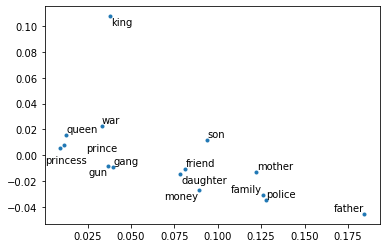

In [298]:
comp1 = 0
comp2 = 1

pyplot.plot(word_emb[indices, comp1], word_emb[indices, comp2], '.')
texts = [pyplot.text(word_emb[i, comp1], word_emb[i, comp2], w) for i, w in zip(indices, target)]
adjust_text(texts)   

## TSNE를 이용한 다차원 시각화

In [126]:
from sklearn.manifold import TSNE

In [299]:
tsne = TSNE()

In [300]:
pos = tsne.fit_transform(word_emb)

45

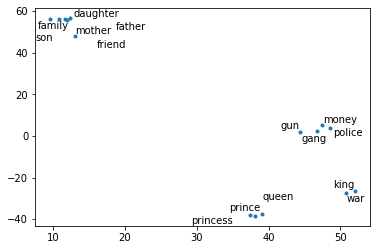

In [301]:
pyplot.plot(pos[indices, 0], pos[indices, 1], '.')
texts = [pyplot.text(pos[i, 0], pos[i, 1], w) for i, w in zip(indices, target)]
adjust_text(texts)

## 코사인 유사도

In [134]:
from sklearn.metrics.pairwise import cosine_similarity

In [302]:
sim = cosine_similarity(word_emb)

In [303]:
sim.shape

(2000, 2000)

In [304]:
i = words.index('money')

In [305]:
pd.DataFrame({'word': words, 'similarity': sim[i]}).sort_values('similarity', ascending=False).head(10)

,word,similarity
1184,money,1.000000
1028,lawyer,0.917476
167,beat,0.907231
1784,taxi,0.901879
1341,policeman,0.873511
537,driver,0.870113
170,beats,0.864734
155,bank,0.864318
152,bag,0.856917
1291,pay,0.851436


## Word2Vec

In [162]:
from gensim.models import Word2Vec

In [163]:
from gensim.utils import simple_preprocess

In [193]:
wv = Word2Vec(size=20, min_count=10, workers=4, sentences=[simple_preprocess(p) for p in plot])

In [194]:
wv.wv['money']

array([-1.6270212, -1.1567942,  5.628484 , -5.98074  ,  1.7161938,
       -3.1820073,  4.3748403, -3.8635185, -3.888927 ,  3.2969096,
       -1.6903508,  4.353754 ,  1.3981246,  3.1829128, -2.2302716,
        2.033425 , -4.043422 , -2.39167  , -1.6813314,  1.3005257],
      dtype=float32)

In [309]:
wv_words = sorted(set(words) & set(wv.wv.vocab))

In [310]:
wvmat = wv.wv[wv_words]

In [311]:
wvmat.shape

(1995, 20)

### 시각화

In [203]:
w2v_tsne = TSNE()

In [204]:
w2v_pos = w2v_tsne.fit_transform(wvmat)

In [314]:
indices = [wv_words.index(w) for w in target]   

61

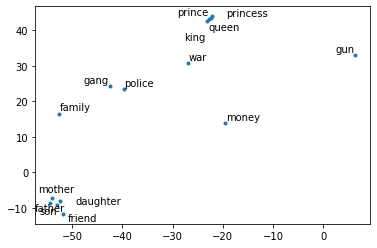

In [315]:
pyplot.plot(w2v_pos[indices, 0], w2v_pos[indices, 1], '.')
texts = [pyplot.text(w2v_pos[i, 0], w2v_pos[i, 1], w) for i, w in zip(indices, target)]
adjust_text(texts)

### 유사 단어

In [316]:
wv.wv.most_similar('money')

[('cash', 0.909034252166748),
 ('drugs', 0.8633865714073181),
 ('winnings', 0.842190146446228),
 ('debt', 0.8359923362731934),
 ('debts', 0.8320214748382568),
 ('payment', 0.8265412449836731),
 ('loan', 0.7961840033531189),
 ('million', 0.7882428169250488),
 ('reward', 0.7823245525360107),
 ('property', 0.7811795473098755)]